In [16]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
import matplotlib.colors as colors

import numpy as np
import os
import rasterio
from rasterio.transform import from_bounds
from scipy.ndimage import gaussian_filter

In [2]:
cover_path = 'data/raster/predictions/{YEAR}.tif'

ned_path = 'data/raster/ned/ned.tif'

point_counts_path = 'data/vector/2019PointCounts.kml'
point_counts = gpd.read_file(point_counts_path)
point_counts.to_crs(epsg=6514, inplace=True)

years = range(2011, 2021)

In [3]:
results = []

# Loop through each year and point to extract cover values
for year in years:
    # Read the raster for this year
    with rasterio.open(cover_path.format(YEAR=year)) as src:
        # Sample the raster at each point location
        cover_values = [x[0] for x in src.sample([(p.x, p.y) for p in point_counts.geometry])]

        # Ensure cover values are integers and handle no data values (255)
        cover_values = [int(val) if val != 255 else np.nan for val in cover_values]

        # Create dataframe with results for this year
        year_df = pd.DataFrame({
            'name': point_counts['Name'],
            'year': year,
            'cover': cover_values,
            'x': [int(p.x) for p in point_counts.geometry],
            'y': [int(p.y) for p in point_counts.geometry]
        })

        results.append(year_df)

# Combine all years into single dataframe
cover_df = pd.concat(results)

In [4]:
cover_2020 = cover_df[cover_df['year'] == 2020][['name', 'cover', 'x', 'y']].rename(columns={'name': 'point_idx', 'cover': 'cover_2020'})
cover_2016 = cover_df[cover_df['year'] == 2016][['name', 'cover', 'x', 'y']].rename(columns={'name': 'point_idx', 'cover': 'cover_2016'})
cover_2011 = cover_df[cover_df['year'] == 2011][['name', 'cover', 'x', 'y']].rename(columns={'name': 'point_idx', 'cover': 'cover_2011'})

cover_change_2020 = cover_2020.merge(cover_2011, on='point_idx')
cover_change_2020['cover_change'] = cover_change_2020['cover_2020'] - cover_change_2020['cover_2011']
cover_change_2020['year_2020'] = 2020
cover_change_2020['year_2011'] = 2011
cover_change_2020 = cover_change_2020[['year_2020', 'cover_2020', 'point_idx', 'year_2011', 'cover_2011', 'cover_change', 'x_x', 'y_x']].rename(columns={'x_x': 'x', 'y_x': 'y'})


cover_change_2016 = cover_2016.merge(cover_2011, on='point_idx')
cover_change_2016['cover_change'] = cover_change_2016['cover_2016'] - cover_change_2016['cover_2011']
cover_change_2016['year_2016'] = 2016
cover_change_2016['year_2011'] = 2011
cover_change_2016 = cover_change_2016[['year_2016', 'cover_2016', 'point_idx', 'year_2011', 'cover_2011', 'cover_change', 'x_x', 'y_x']].rename(columns={'x_x': 'x', 'y_x': 'y'})

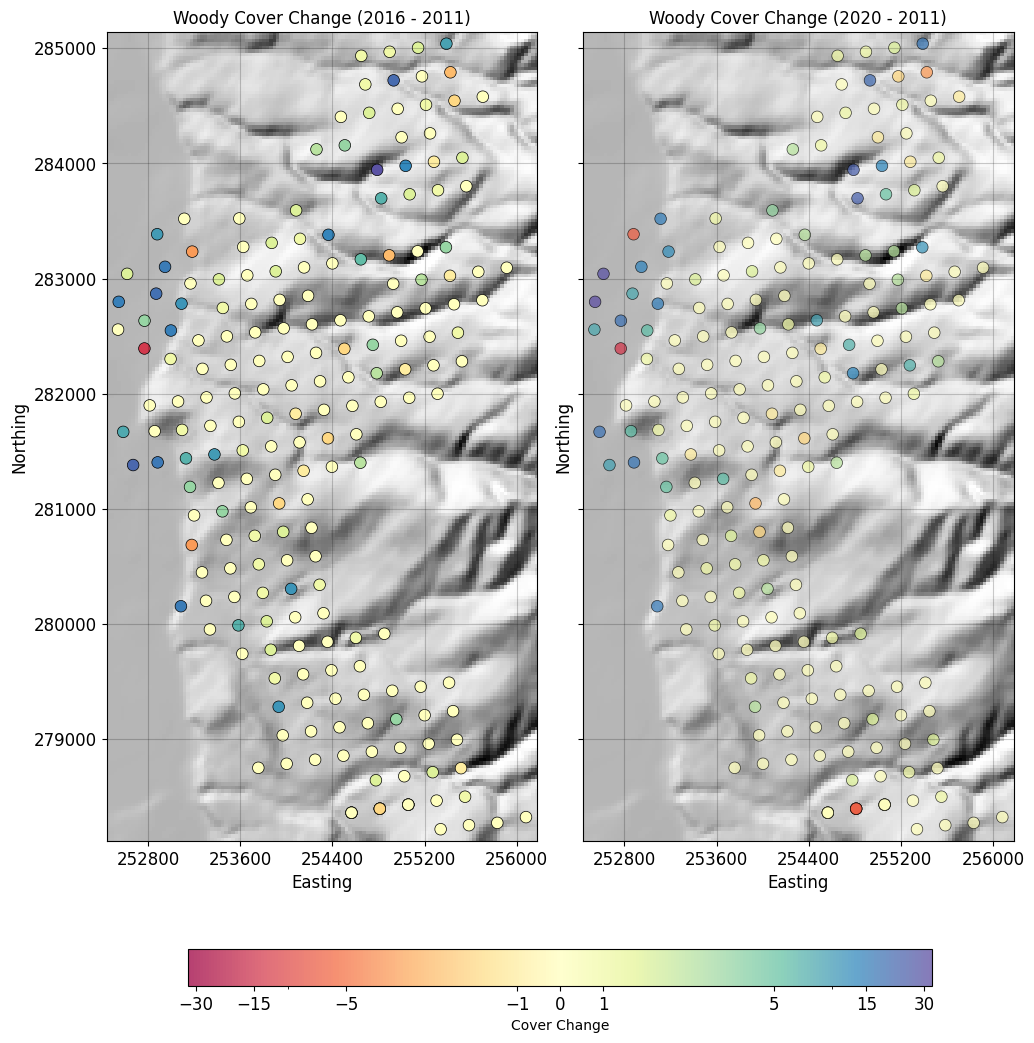

Points with significant change in 2020: ['49', '38', '37', '10', '6', '132', '163', '239', '467', '468', '469', '473', '480', '482', '484', '485', '67', '126']


In [39]:
# Calculate overall min/max changes
min_change = min(cover_change_2016['cover_change'].min(), cover_change_2020['cover_change'].min())
max_change = max(cover_change_2016['cover_change'].max(), cover_change_2020['cover_change'].max())


# Calculate bounds from points with small buffer
xmin = min(cover_change_2020['x'].min(), cover_change_2016['x'].min()) - 100
xmax = max(cover_change_2020['x'].max(), cover_change_2016['x'].max()) + 100
ymin = min(cover_change_2020['y'].min(), cover_change_2016['y'].min()) - 100
ymax = max(cover_change_2020['y'].max(), cover_change_2016['y'].max()) + 100

# Load and process DEM for hillshade
with rasterio.open(ned_path) as src:
    # Get window for cropped region
    window = rasterio.windows.from_bounds(xmin, ymin, xmax, ymax, src.transform)

    # Read cropped elevation data
    elevation = src.read(1, window=window, masked=True)
    elevation = gaussian_filter(elevation.astype(float), sigma=0.75)

    # Get transform for cropped region
    cropped_transform = rasterio.windows.transform(window, src.transform)

    # Generate hillshade
    ls = LightSource(azdeg=315, altdeg=45)
    hillshade = ls.hillshade(elevation, vert_exag=2, dx=src.res[0], dy=src.res[1])

    # Create the plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 14), sharex=True, sharey=True, gridspec_kw={'wspace':0.05})
    
    # Plot hillshade as background
    for ax in axes:
        ax.imshow(hillshade, extent=(xmin, xmax, ymin, ymax), cmap='gray')

    # Create logarithmic normalization with calculated bounds
    lognorm = colors.SymLogNorm(linthresh=5, linscale=1, vmin=-max_change, vmax=max_change)

    # Overlay points for 2016
    scatter_2016 = axes[0].scatter(
        cover_change_2016["x"],
        cover_change_2016["y"],
        c=cover_change_2016["cover_change"].clip(-max_change, max_change),
        cmap='Spectral',
        norm=lognorm,
        s=70,
        edgecolors='black',
        linewidths=0.5,
        alpha=1.0
    )
    axes[0].set_title('Woody Cover Change (2016 - 2011)')
    
    # Overlay points for 2020
    scatter_2020 = axes[1].scatter(
        cover_change_2020["x"],
        cover_change_2020["y"],
        c=cover_change_2020["cover_change"].clip(-max_change, max_change),
        cmap='Spectral',
        norm=lognorm,
        s=70,
        edgecolors='black',
        linewidths=0.5,
        alpha=0.75
    )
    axes[1].set_title('Woody Cover Change (2020 - 2011)')

    # Create tick list with calculated bounds and specified values
    tick_list = [-60, -30, -15, -5, -1, 0, 1, 5, 15, 30, 60]
    tick_list = sorted(list(set(tick_list)))  # Remove duplicates and sort

    # Add shared colorbar
    cbar = fig.colorbar(scatter_2020, ax=axes, label='Cover Change', orientation='horizontal', 
                       shrink=0.8, pad=0.1, ticks=tick_list)
    cbar.ax.tick_params(labelsize=12)

    # Format colorbar ticks to avoid scientific notation
    cbar.formatter = ticker.ScalarFormatter(useOffset=False)
    cbar.formatter.set_scientific(False)
    cbar.update_ticks()

    # Set labels and titles
    for ax in axes:
        ax.set_xlabel('Easting', fontsize=12)
        ax.set_ylabel('Northing', fontsize=12)
        ax.set_aspect('equal', adjustable='box')
        ax.tick_params(axis='both', labelsize=12)
        ax.grid(True, color='black', alpha=0.2)
        
        # Reduce number of x-axis ticks
        ax.xaxis.set_major_locator(plt.MaxNLocator(5))
    
    # Set plot limits to match the point bounds
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    
    #plt.tight_layout()
    path_to_cover_change_plots = 'results/figures/cover_change_plots.png'
    plt.savefig(path_to_cover_change_plots, dpi=300, bbox_inches='tight')
    plt.show()
    
# Extract point_idx for rows where abs(cover_change) > 10 for 2020
significant_change_2020 = cover_change_2020[abs(cover_change_2020["cover_change"]) > 10]
significant_points_2020 = significant_change_2020["point_idx"].tolist()

print(f"Points with significant change in 2020: {significant_points_2020}")

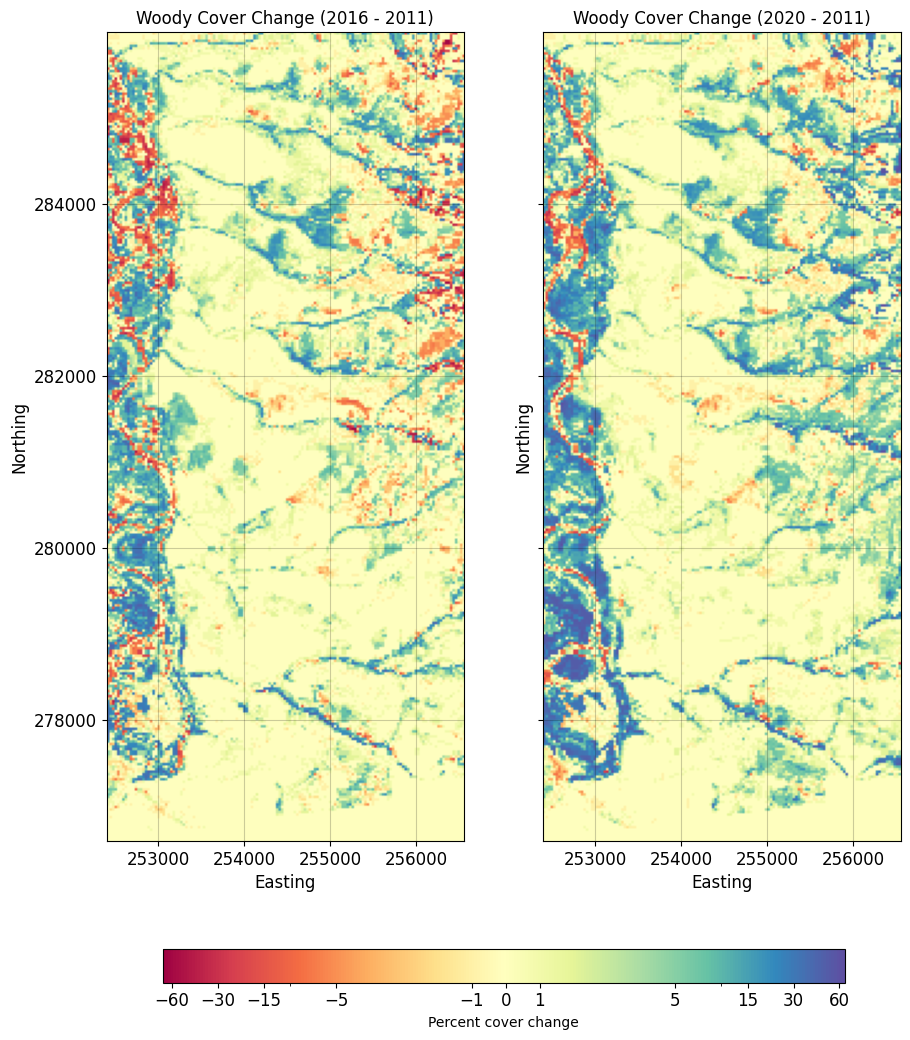

Minimum change: -69
Maximum change: 65


In [37]:
# Read in raster data for each year
cover_rasters = {}
for year in [2011, 2016, 2020]:
    with rasterio.open(cover_path.format(YEAR=year)) as src:
        cover_rasters[year] = src.read(1).astype(np.int32)  # Explicitly convert to int32
        if year == 2011:  # Save metadata from first raster
            transform = src.transform
            bounds = src.bounds
            xmin, ymin, xmax, ymax = bounds

# Calculate raster differences
diff_2016 = cover_rasters[2016] - cover_rasters[2011]
diff_2020 = cover_rasters[2020] - cover_rasters[2011]

# Calculate overall min/max changes
min_change = min(np.min(diff_2016), np.min(diff_2020))
max_change = max(np.max(diff_2016), np.max(diff_2020))

# Create the plot
fig, axes = plt.subplots(1, 2, figsize=(11, 14), sharex=True, sharey=True, gridspec_kw={'wspace':0.05})

# Create logarithmic normalization with calculated bounds
lognorm = colors.SymLogNorm(linthresh=5, linscale=1, vmin=min_change, vmax=max_change)

# Plot 2016-2011 difference
im1 = axes[0].imshow(
    diff_2016,
    cmap='Spectral',
    norm=lognorm,
    extent=[bounds.left, bounds.right, bounds.bottom, bounds.top]
)
axes[0].set_title('Woody Cover Change (2016 - 2011)')

# Plot 2020-2011 difference  
im2 = axes[1].imshow(
    diff_2020, 
    cmap='Spectral',
    norm=lognorm,
    extent=[bounds.left, bounds.right, bounds.bottom, bounds.top]
)
axes[1].set_title('Woody Cover Change (2020 - 2011)')

# Create tick list with calculated bounds and specified values
tick_list = [-60, -30, -15, -5, -1, 0, 1, 5, 15, 30, 60]
tick_list = sorted(list(set(tick_list)))  # Remove duplicates and sort

# Add shared colorbar with specific ticks
cbar = fig.colorbar(im2, ax=axes, label='Percent cover change', orientation='horizontal', 
                   shrink=0.8, pad=0.1, ticks=tick_list)
cbar.ax.tick_params(labelsize=12)

# Format colorbar ticks to avoid scientific notation
from matplotlib import ticker
cbar.formatter = ticker.ScalarFormatter(useOffset=False)
cbar.formatter.set_scientific(False)
cbar.update_ticks()

# Set labels and formatting
for ax in axes:
    ax.set_xlabel('Easting', fontsize=12)
    ax.set_ylabel('Northing', fontsize=12)
    ax.set_aspect('equal', adjustable='box')
    ax.tick_params(axis='both', labelsize=12)
    ax.grid(True, color='black', alpha=0.2)

#plt.tight_layout()
path_to_raster_change_plots = 'results/figures/raster_cover_change_plots.png'
plt.savefig(path_to_raster_change_plots, dpi=300, bbox_inches='tight')
plt.show()

# Print the actual min and max changes
print(f"Minimum change: {min_change}")
print(f"Maximum change: {max_change}")
